# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline      #It renders figures in a notebook (instead of displaying a dump of the figure object).

## Read in an Image

In [ ]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
    
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
-0.5597964376590331


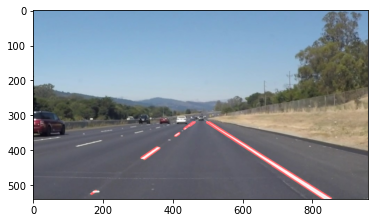

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

#drawing static image in our notebook (standard solution to add plots to Jupyter notebook)
%matplotlib inline


def read_image():
    img = mpimg.imread('test_images/solidWhiteRight.jpg')
    print('This image is:', type(img), 'with dimensions:', img.shape)
    return img  

def grayscale(img):
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #using RGB to gray because image has been imported using mpimg.imread (use BGR in case you used cv2.imread)
    """NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)       
    draw_lines(line_img, lines)
    #print(lines[0][0][2])    
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)



"""Reading in an image
Input the image location in the function defined at the top"""
image = read_image()
#plt.imshow(image)   """Test to check if image loaded properly"""
        
"""Convert image to a grayscale image named gray_img"""
gray_img = grayscale(image) 
#plt.imshow(gray_img, cmap='gray') 

"""Apply Gaussian filter before applying canny function"""
filtered_gray_img=gaussian_blur(gray_img,5)

"""Apply canny to get pixels at the gradient of color intensity"""
canny_img = canny(filtered_gray_img,50,150)
#plt.imshow(canny_img,cmap='gray')   

"""Apply mask: We'll keep only the part ocupied by lane in front of the vehicle in the image
      Assumption: Camera is mounted at the front of the vehicle"""

# (1) Add vertices. Each coordinate tuple should be of the form (x,y). Origin is at the top left of the image
vertices=np.array([[(60,540),(453,320),(523,320),(920,540)]],dtype=np.int32)

print((320-540)/(453-60))

# (2) Apply mask on the image and ONLY keep the region formed by the above polygon
roi_img=region_of_interest(canny_img,vertices)
#plt.imshow(roi_img,cmap='gray')   

"""Apply Hough Transform"""
line_img=hough_lines(roi_img,2,np.pi/180,50,5,10)
plt.imshow(line_img)

combo=cv2.addWeighted(image,1,line_img,1,0)
plt.imshow(combo)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import cv2
    import statistics

    #drawing static image in our notebook (standard solution to add plots to Jupyter notebook)
    %matplotlib inline
    #you can keep toggling between this and %matplotlib notebook to track coordinates of pixels in the image

    """
    def read_image():
        img = mpimg.imread('test_images/solidWhiteRight.jpg')
        print('This image is:', type(img), 'with dimensions:', img.shape)
        return img  
    """

    def grayscale(img):

        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #using RGB to gray because image has been imported using mpimg.imread (use BGR in case you used cv2.imread)
        """NOTE: to see the returned image as grayscale
        (assuming your grayscaled image is called 'gray')
        you should call plt.imshow(gray, cmap='gray')"""

    def canny(img, low_threshold, high_threshold):
        """Applies the Canny transform"""
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(img, kernel_size):
        """Applies a Gaussian Noise kernel"""
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(img, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image    

    def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        global lines
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)       
        draw_lines(line_img, lines)
        #print(lines[0][0][2])    
        return line_img

    def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
        """
        This function draws `lines` with `color` and `thickness`.    
        Lines are drawn on the image inplace (mutates the image).
        """
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)


    """Reading in an image
    Input the image location in the function defined at the top"""
    #image = read_image()
    #plt.imshow(image)   """Test to check if image loaded properly"""

    """Convert image to a grayscale image named gray_img"""
    gray_img = grayscale(image) 
    #plt.imshow(gray_img, cmap='gray') 

    """Apply Gaussian filter before applying canny function"""
    filtered_gray_img=gaussian_blur(gray_img,5)

    """Apply canny to get pixels at the gradient of color intensity"""
    canny_img = canny(filtered_gray_img,50,150)
    #plt.imshow(canny_img,cmap='gray')   

    """Apply mask: We'll keep only the part ocupied by lane in front of the vehicle in the image
          Assumption: Camera is mounted at the front of the vehicle"""

    # (1) Add vertices. Each coordinate tuple should be of the form (x,y). Origin is at the top left of the image
    #vertices=np.array([[(60,540),(453,320),(523,320),(920,540)]],dtype=np.int32)
    vertices=np.array([[((60/960)*image.shape[1],(540/540)*image.shape[0]),((453/960)*image.shape[1],(320/540)*image.shape[0]),((523/960)*image.shape[1],(320/540)*image.shape[0]),((920/960)*image.shape[1],(540/540)*image.shape[0])]],dtype=np.int32)

    # (2) Apply mask on the image and ONLY keep the region formed by the above polygon
    roi_img=region_of_interest(canny_img,vertices)
    #plt.imshow(roi_img,cmap='gray')   

    """Apply Hough Transform"""
    hough_line_img=hough_lines(roi_img,2,np.pi/180,50,5,10)
    #plt.imshow(hough_line_img)


    """Equation of line: y=mx+c (m = slope, c = y intercept)"""

    """We want to draw 2 lines from the top part of our region of interest to the bottom edge of the region. 
    To do that, we'll require the coordinates of the top most point of lines and slope of the line"""


    "First, we'll find a ALLOWED range for the slope of our lines to ignore randomly oriented lines that come by mistake"

    #finding the slope of the sides of our trapezium. 
    #We need to remember viewing the cartesian plane from top left corner
    slope_left_edge= (vertices[0][1][1]-vertices[0][0][1])/(vertices[0][1][0]-vertices[0][0][0])
    slope_right_edge= (vertices[0][2][1]-vertices[0][3][1])/(vertices[0][2][0]-vertices[0][3][0])
    #result: -0.54 and 0.55 respectively
    # arctan(0.55)=30 degrees. The slope of lanes are steeper than our polygon boundary and should be near 45 degrees(roughly).  
    #So m should lie between 2.144 and 0.466 (corresponding to inverse of 65 and 25 degrees) 


    """Task:1- Finding average slope of lines on the left side and right side of the lane"""
    """Task:2- Taking intersection of all lines on the left side with y_top (i.e. topmost side of our mask polygon)
               We'll find the x coordinate of each line's intersection with that line. We'll then average it"""

    m_left=[]    #intializing lists to store values for individual lines. Later we'll average the values
    m_right=[]
    x_top_left=[]
    x_top_right=[]
    y_top=vertices[0][1][1]

    for line in lines:      #"lines" is a global variable declared in "hough_lines" function
        #print(line)
        for x1,y1,x2,y2 in line:
            m=(y2-y1)/(x2-x1)
            c=((x2)*(y1)-(x1)*(y2))/(x2-x1)
            if m<0 and m>-1.2 and m<-0.55:
                m_left.append(m)
                x_top_left.append((y_top-c)/m)
            if m>0 and m>0.55 and m<1.2:
                m_right.append(m)
                x_top_right.append((y_top-c)/m)

    if len(m_left)>0 and len(m_right)>0:
        m_left_avg=statistics.mean(m_left)
        m_right_avg=statistics.mean(m_right)
    elif len(m_left)==0 and len(m_right)>0:
        m_right_avg=statistics.mean(m_right)
        m_left_avg=-m_right_avg
    elif len(m_left)>0 and len(m_right)==0:
        m_left_avg=statistics.mean(m_left)
        m_right_avg=-m_left_avg
    else:
        m_left_avg=slope_left_edge
        m_right_avg=slope_right_edge
        
    x_top_middle_point=int((vertices[0][1][0]+vertices[0][2][0])/2)
    
    if len(x_top_left)>0 and len(x_top_right)>0:
        x_top_left_avg=int(statistics.mean(x_top_left))
        x_top_right_avg=int(statistics.mean(x_top_right))
    elif len(x_top_left)==0 and len(x_top_right)>0:
        x_top_right_avg=int(statistics.mean(x_top_right))
        x_top_left_avg= x_top_middle_point-(x_top_right_avg-x_top_middle_point)
    elif len(x_top_left)>0 and len(x_top_right)==0:
        x_top_left_avg=int(statistics.mean(x_top_left))
        x_top_right_avg=x_top_middle_point+(x_top_middle_point-x_top_left_avg)
    else:
        x_top_left_avg=int(vertices[0][1][0])
        x_top_right_avg=int(vertices[0][2][0])

        
    c_left=(y_top)-(m_left_avg*x_top_left_avg)
    c_right=(y_top)-(m_right_avg*x_top_right_avg)

    y_bottom=vertices[0][0][1]
    x_bottom_left= int((y_bottom-c_left)/m_left_avg) 
    x_bottom_right= int((y_bottom-c_right)/m_right_avg)
    print(y_bottom)
    print(x_bottom_left)
    print(x_bottom_right)

    lane_lines_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)       #3-D image. Stacking not required


    #vertices=np.array([[(x_bottom_left,y_bottom),(x_top_left_avg,y_top),(x_bottom_right,y_bottom),(x_top_right_avg,y_top)]])
    cv2.line(lane_lines_img, (x_bottom_left,y_bottom),(x_top_left_avg,y_top), [255,0,0], 15)
    cv2.line(lane_lines_img, (x_bottom_right,y_bottom),(x_top_right_avg,y_top), [255,0,0], 15)

    #plt.imshow(lane_lines_img)

    combo=cv2.addWeighted(image,1,lane_lines_img,0.5,0)
    plt.imshow(combo)

    combo2=cv2.addWeighted(image,1,hough_line_img,0.5,0)
    plt.imshow(combo2)

    return combo

Let's try the one with the solid white lane on the right first ...

t:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

540
157
859
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

540
157
859



t:   1%|▏         | 3/221 [00:00<00:26,  8.36it/s, now=None]

540
155
859
540
149



t:   2%|▏         | 4/221 [00:00<00:29,  7.32it/s, now=None]

862
540
157
861



t:   3%|▎         | 6/221 [00:00<00:30,  7.13it/s, now=None]

540
157
862
540
148
857



t:   4%|▎         | 8/221 [00:01<00:27,  7.88it/s, now=None]

540
149
863
540
147
862



t:   5%|▍         | 10/221 [00:01<00:25,  8.17it/s, now=None]

540
150
855
540
153
862



t:   5%|▌         | 12/221 [00:01<00:25,  8.35it/s, now=None]

540
153
847
540
158
844



t:   6%|▋         | 14/221 [00:01<00:26,  7.94it/s, now=None]

540
151
841
540
142
844



t:   7%|▋         | 16/221 [00:01<00:25,  8.19it/s, now=None]

540
143
841
540
140
848



t:   8%|▊         | 18/221 [00:02<00:25,  8.11it/s, now=None]

540
148
842
540
147
856
540


t:   9%|▉         | 20/221 [00:02<00:23,  8.69it/s, now=None]


143
845
540
141
840



t:  10%|▉         | 22/221 [00:02<00:22,  8.72it/s, now=None]

540
150
841
540
146
845



t:  11%|█▏        | 25/221 [00:02<00:20,  9.60it/s, now=None]

540
153
844
540
158
840
540
148
841



t:  12%|█▏        | 27/221 [00:03<00:18, 10.47it/s, now=None]

540
149
848
540
153
845
540
150
843



t:  14%|█▍        | 31/221 [00:03<00:15, 12.00it/s, now=None]

540
145
846
540
145
847
540
157
848
540
149
849



t:  15%|█▍        | 33/221 [00:06<01:34,  2.00it/s, now=None]

540
149
854



t:  16%|█▌        | 35/221 [00:06<01:03,  2.92it/s, now=None]

540
151
848
540
150
856



t:  17%|█▋        | 37/221 [00:07<01:10,  2.60it/s, now=None]

540
156
846
540
153
846



t:  18%|█▊        | 39/221 [00:08<00:50,  3.62it/s, now=None]

540
154
850
540
150
845



t:  19%|█▊        | 41/221 [00:08<00:36,  4.94it/s, now=None]

540
146
839
540
146
838
540


t:  19%|█▉        | 43/221 [00:08<00:29,  5.97it/s, now=None]


158
843
540
151
831
540
141
846



t:  21%|██▏       | 47/221 [00:08<00:21,  8.04it/s, now=None]

540
154
844
540
153
841
540
158
847



t:  22%|██▏       | 49/221 [00:11<01:24,  2.02it/s, now=None]

540
152
849
540
146
843



t:  23%|██▎       | 51/221 [00:11<00:52,  3.24it/s, now=None]

540
141
842
540
136
848



t:  24%|██▎       | 52/221 [00:11<00:44,  3.78it/s, now=None]

540
136
846



t:  24%|██▍       | 54/221 [00:12<00:38,  4.39it/s, now=None]

540
141
846
540
138
855



t:  26%|██▌       | 57/221 [00:12<00:27,  5.96it/s, now=None]

540
141
851
540
135
836



t:  26%|██▌       | 58/221 [00:12<00:25,  6.45it/s, now=None]

540
145
837
540
144
839



t:  27%|██▋       | 59/221 [00:12<00:24,  6.65it/s, now=None]

540
139
843



t:  28%|██▊       | 61/221 [00:13<00:26,  6.06it/s, now=None]

540
133
842
540
130
845



t:  29%|██▉       | 64/221 [00:13<00:20,  7.58it/s, now=None]

540
135
834
540
129
839
540
139
842



t:  30%|██▉       | 66/221 [00:13<00:18,  8.47it/s, now=None]

540
133
827
540
120
838



t:  31%|███       | 68/221 [00:14<00:18,  8.16it/s, now=None]

540
126
840
540
115
839



t:  31%|███       | 69/221 [00:14<00:20,  7.32it/s, now=None]

540
127
840
540
145
830



t:  33%|███▎      | 72/221 [00:16<00:56,  2.63it/s, now=None]

540
124
832
540
132
834



t:  34%|███▍      | 75/221 [00:17<00:35,  4.17it/s, now=None]

540
126
829
540
125
838
540
121
837



t:  34%|███▍      | 76/221 [00:17<00:29,  4.96it/s, now=None]

540
125
831



t:  36%|███▌      | 79/221 [00:17<00:23,  5.93it/s, now=None]

540
113
826
540
133
827
540
117
820
540
119
825



t:  37%|███▋      | 82/221 [00:18<00:23,  5.79it/s, now=None]

540
113
820
540


t:  38%|███▊      | 84/221 [00:18<00:20,  6.83it/s, now=None]


120
831
540
118
826
540
107
829



t:  39%|███▉      | 86/221 [00:18<00:18,  7.23it/s, now=None]

540
107
823
540
115
823
540


t:  40%|███▉      | 88/221 [00:18<00:16,  8.01it/s, now=None]


121
827
540
127
823



t:  41%|████      | 90/221 [00:19<00:17,  7.61it/s, now=None]

540
125
824
540
104
818



t:  41%|████      | 91/221 [00:19<00:18,  7.07it/s, now=None]

540
119
820
540
122
812



t:  43%|████▎     | 94/221 [00:19<00:16,  7.62it/s, now=None]

540
124
813
540
123
816



t:  43%|████▎     | 95/221 [00:20<00:54,  2.32it/s, now=None]

540
120
818



t:  43%|████▎     | 96/221 [00:22<01:33,  1.34it/s, now=None]

540
116
826



t:  44%|████▍     | 97/221 [00:22<01:16,  1.62it/s, now=None]


540
128
820
540
125
827


t:  45%|████▌     | 100/221 [00:22<00:43,  2.78it/s, now=None]

540
125
828
540
114
820



t:  46%|████▌     | 102/221 [00:23<00:29,  4.07it/s, now=None]

540
127
823
540
127
823



t:  48%|████▊     | 105/221 [00:23<00:21,  5.35it/s, now=None]

540
137
822
540
139
826



t:  48%|████▊     | 107/221 [00:23<00:17,  6.38it/s, now=None]

540
127
825
540
134
831
540
139
840



t:  49%|████▉     | 109/221 [00:23<00:15,  7.26it/s, now=None]

540
133
827
540
133
830
540
139
831



t:  50%|█████     | 111/221 [00:24<00:13,  8.16it/s, now=None]


540
136
830
540
132
828


t:  51%|█████     | 113/221 [00:24<00:12,  8.45it/s, now=None]

540
132
827



t:  52%|█████▏    | 116/221 [00:24<00:14,  7.23it/s, now=None]

540
123
839
540
141
833
540
132
834



t:  53%|█████▎    | 118/221 [00:24<00:12,  8.07it/s, now=None]

540
132
839
540
131
837
540
127
840



t:  54%|█████▍    | 120/221 [00:25<00:11,  8.91it/s, now=None]

540
127
840
540
144
841



t:  55%|█████▌    | 122/221 [00:27<00:47,  2.10it/s, now=None]


540
137
847


t:  56%|█████▌    | 124/221 [00:28<00:30,  3.14it/s, now=None]

540
141
844
540
134
845



t:  57%|█████▋    | 126/221 [00:28<00:25,  3.77it/s, now=None]

540
138
844
540
138
845



t:  57%|█████▋    | 127/221 [00:28<00:20,  4.59it/s, now=None]


540
159
853
540
139
846


t:  59%|█████▉    | 130/221 [00:29<00:15,  5.92it/s, now=None]

540
159
845
540
145
851



t:  60%|█████▉    | 132/221 [00:29<00:12,  7.13it/s, now=None]

540
147
850
540
156
853



t:  61%|██████    | 134/221 [00:29<00:10,  8.07it/s, now=None]

540
156
855
540
150
849
540


t:  62%|██████▏   | 137/221 [00:29<00:09,  9.14it/s, now=None]


153
852
540
140
858
540


t:  62%|██████▏   | 138/221 [00:29<00:09,  8.85it/s, now=None]


149
860
540
152
859



t:  63%|██████▎   | 140/221 [00:30<00:10,  7.44it/s, now=None]

540
148
860
540
149
852



t:  64%|██████▍   | 142/221 [00:30<00:12,  6.35it/s, now=None]

540
148
855
540
155
854



t:  65%|██████▍   | 143/221 [00:33<01:13,  1.06it/s, now=None]

540
147
845
540
157
846



t:  67%|██████▋   | 147/221 [00:33<00:37,  1.96it/s, now=None]

540
162
847
540
157
854
540
156
860



t:  67%|██████▋   | 149/221 [00:33<00:27,  2.63it/s, now=None]

540
164
859
540
162
857
540
160
859



t:  69%|██████▉   | 153/221 [00:34<00:15,  4.40it/s, now=None]

540
152
861
540
170
862
540
160
856



t:  70%|███████   | 155/221 [00:34<00:12,  5.40it/s, now=None]

540
170
864
540
161
860
540
161
867



t:  72%|███████▏  | 159/221 [00:34<00:08,  7.35it/s, now=None]

540
162
861
540
167
870
540
168
861



t:  73%|███████▎  | 161/221 [00:34<00:07,  8.31it/s, now=None]

540
162
872
540
169
872
540
172
879



t:  75%|███████▍  | 165/221 [00:35<00:05,  9.75it/s, now=None]

540
181
878
540
177
879
540
177
879



t:  76%|███████▌  | 167/221 [00:35<00:05, 10.15it/s, now=None]

540
181
875
540
178
884



t:  76%|███████▋  | 169/221 [00:35<00:06,  8.38it/s, now=None]

540
186
876
540
179
867
540
182
874



t:  78%|███████▊  | 173/221 [00:36<00:04, 10.42it/s, now=None]

540
182
879
540
181
879
540
181
885
540
176
865



t:  79%|███████▉  | 175/221 [00:38<00:17,  2.59it/s, now=None]

540
179
879



t:  80%|████████  | 177/221 [00:38<00:14,  3.04it/s, now=None]

540
180
876
540
188
873



t:  81%|████████  | 179/221 [00:38<00:08,  4.70it/s, now=None]

540
184
880
540
190
881
540


t:  82%|████████▏ | 181/221 [00:39<00:07,  5.71it/s, now=None]


184
887
540
188
880
540
181
885



t:  84%|████████▎ | 185/221 [00:39<00:04,  7.77it/s, now=None]

540
190
877
540
188
877
540
183
881



t:  85%|████████▍ | 187/221 [00:39<00:04,  8.39it/s, now=None]

540
191
883
540
190
879
540
175
882



t:  86%|████████▋ | 191/221 [00:40<00:03,  9.84it/s, now=None]

540
189
890
540
180
890
540
182
897



t:  87%|████████▋ | 193/221 [00:40<00:02, 10.16it/s, now=None]

540
178
896
540
182
888
540
185
883



t:  89%|████████▉ | 197/221 [00:40<00:02, 11.23it/s, now=None]

540
180
874
540
186
873
540
183
880



t:  90%|█████████ | 199/221 [00:40<00:01, 11.21it/s, now=None]

540
177
888
540
186
879
540
180
879



t:  92%|█████████▏| 203/221 [00:41<00:01, 11.66it/s, now=None]

540
191
889
540
183
883
540
190
886



t:  93%|█████████▎| 205/221 [00:41<00:01, 11.67it/s, now=None]

540
187
882
540
184
890
540
186
887



t:  94%|█████████▎| 207/221 [00:41<00:01, 11.40it/s, now=None]

540
180
887
540
182
893



t:  95%|█████████▍| 209/221 [00:42<00:02,  4.66it/s, now=None]

540
178
898



t:  96%|█████████▌| 212/221 [00:44<00:04,  2.14it/s, now=None]

540
170
899
540
171
898
540
177
895



t:  97%|█████████▋| 214/221 [00:44<00:02,  2.83it/s, now=None]

540
178
890
540
174
895
540
177
888



t:  98%|█████████▊| 217/221 [00:44<00:00,  4.40it/s, now=None]

540
184
893
540
177
886



t:  99%|█████████▉| 219/221 [00:44<00:00,  5.39it/s, now=None]

540
176
885
540
174
883
540
187
886



t: 100%|██████████| 221/221 [00:44<00:00,  6.42it/s, now=None]
                                                              

540
174
881


t:  39%|███▉      | 98/251 [14:10<00:24,  6.30it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 49.6 s


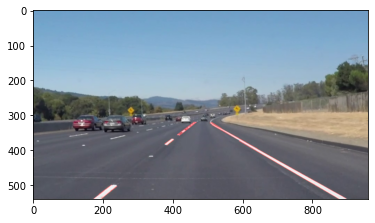

In [12]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(4,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

t:   0%|          | 0/681 [00:00<?, ?it/s, now=None]

540
114
835
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

540
114
835



t:   0%|          | 3/681 [00:00<00:51, 13.06it/s, now=None]

540
112
838
540
117
835



t:   1%|          | 5/681 [00:00<01:19,  8.52it/s, now=None]

540
121
828
540
136
828



t:   1%|          | 7/681 [00:00<01:14,  9.00it/s, now=None]

540
143
828
540
151
829



t:   1%|▏         | 10/681 [00:01<01:13,  9.19it/s, now=None]

540
139
826
540
152
837
540


t:   2%|▏         | 11/681 [00:01<01:11,  9.36it/s, now=None]


134
839
540
149
840



t:   2%|▏         | 14/681 [00:04<09:03,  1.23it/s, now=None]

540
130
849
540
145
843
540
147
839



t:   2%|▏         | 16/681 [00:05<06:35,  1.68it/s, now=None]

540
140
831
540
149
850
540
143
845



t:   3%|▎         | 20/681 [00:05<03:43,  2.95it/s, now=None]

540
149
844
540
167
849



t:   3%|▎         | 22/681 [00:05<02:48,  3.92it/s, now=None]

540
144
850
540
143
857
540
165
861
540
157
851



t:   4%|▍         | 26/681 [00:05<01:45,  6.21it/s, now=None]

540
157
846
540
164
852
540
156
853



t:   4%|▍         | 30/681 [00:06<01:12,  9.04it/s, now=None]

540
176
857
540
155
859
540
160
860
540


t:   5%|▍         | 32/681 [00:06<01:03, 10.22it/s, now=None]


156
862
540
165
852
540
154
843



t:   5%|▍         | 34/681 [00:06<00:58, 11.08it/s, now=None]

540
162
876
540
162
880
540
161
857



t:   6%|▌         | 38/681 [00:06<00:53, 11.98it/s, now=None]

540
162
863
540
158
862
540
159
867
540
160
873



t:   6%|▌         | 40/681 [00:06<01:08,  9.40it/s, now=None]

540
156
867



t:   6%|▌         | 42/681 [00:09<05:30,  1.93it/s, now=None]

540
153
872
540
150
870



t:   6%|▋         | 44/681 [00:10<03:21,  3.17it/s, now=None]

540
158
871
540
156
854



t:   7%|▋         | 47/681 [00:10<02:12,  4.80it/s, now=None]

540
156
858
540
155
860
540
156
854



t:   7%|▋         | 49/681 [00:10<01:47,  5.88it/s, now=None]

540
156
861
540
153
871
540
146
863



t:   7%|▋         | 51/681 [00:10<01:29,  7.05it/s, now=None]


540
147
859
540
147
871


t:   8%|▊         | 55/681 [00:11<01:13,  8.48it/s, now=None]

540
144
848
540
150
871
540
151
864



t:   8%|▊         | 57/681 [00:11<01:07,  9.22it/s, now=None]

540
155
862
540
154
870
540
147
849



t:   9%|▉         | 61/681 [00:11<00:58, 10.62it/s, now=None]

540
158
850
540
146
867
540
146
863



t:   9%|▉         | 63/681 [00:11<00:56, 11.03it/s, now=None]

540
145
861
540
135
853
540
142
864



t:  10%|▉         | 67/681 [00:12<00:52, 11.75it/s, now=None]

540
145
844
540
137
858
540
143
856
540
146
846



t:  10%|█         | 69/681 [00:14<04:33,  2.24it/s, now=None]

540
140
843



t:  11%|█         | 72/681 [00:15<03:27,  2.93it/s, now=None]

540
146
849
540
142
848
540
157
849



t:  11%|█         | 74/681 [00:15<02:39,  3.81it/s, now=None]

540
143
841
540
143
841
540
150
841



t:  11%|█         | 76/681 [00:15<02:05,  4.84it/s, now=None]

540
148
855
540
153
845



t:  12%|█▏        | 80/681 [00:16<01:28,  6.77it/s, now=None]

540
146
835
540
144
843
540
153
850



t:  12%|█▏        | 82/681 [00:16<01:15,  7.94it/s, now=None]

540
146
832
540
145
844
540
142
836



t:  13%|█▎        | 86/681 [00:16<01:02,  9.50it/s, now=None]

540
140
843
540
149
845
540


t:  13%|█▎        | 88/681 [00:16<00:57, 10.27it/s, now=None]


149
837
540
146
837
540
139
850



t:  13%|█▎        | 90/681 [00:16<00:54, 10.94it/s, now=None]

540
142
841
540
133
854
540
137
840



t:  14%|█▍        | 94/681 [00:17<00:56, 10.35it/s, now=None]

540
142
831
540
141
840
540
147
832



t:  14%|█▍        | 96/681 [00:17<00:52, 11.22it/s, now=None]

540
147
837
540
150
830
540
149
830



t:  14%|█▍        | 98/681 [00:17<00:49, 11.83it/s, now=None]

540
153
838
540
145
838



t:  15%|█▍        | 101/681 [00:20<03:58,  2.43it/s, now=None]

540
154
836
540
146
838



t:  15%|█▌        | 103/681 [00:21<02:53,  3.34it/s, now=None]

540
154
857
540


t:  15%|█▌        | 105/681 [00:21<02:15,  4.26it/s, now=None]


151
844
540
148
841
540
141
843



t:  16%|█▌        | 107/681 [00:21<01:49,  5.26it/s, now=None]

540
149
836
540
144
831
540
143
842



t:  16%|█▌        | 110/681 [00:21<01:21,  7.02it/s, now=None]


540
154
838
540
146
848


t:  16%|█▋        | 112/681 [00:22<01:15,  7.55it/s, now=None]

540
140
850
540
144
835



t:  17%|█▋        | 114/681 [00:22<01:13,  7.74it/s, now=None]

540
148
845
540
145
843



t:  17%|█▋        | 116/681 [00:22<01:21,  6.97it/s, now=None]

540
151
847
540
150
849



t:  17%|█▋        | 117/681 [00:22<01:24,  6.67it/s, now=None]

540
148
844



t:  17%|█▋        | 119/681 [00:23<01:32,  6.06it/s, now=None]

540
141
841
540
148
849



t:  18%|█▊        | 121/681 [00:23<01:26,  6.46it/s, now=None]

540
144
847
540
150
841



t:  18%|█▊        | 123/681 [00:26<07:28,  1.24it/s, now=None]

540
143
847
540
150
838
540


t:  18%|█▊        | 125/681 [00:27<05:27,  1.70it/s, now=None]


148
846
540
144
845



t:  19%|█▊        | 127/681 [00:27<03:16,  2.81it/s, now=None]

540
155
847
540
144
842



t:  19%|█▉        | 129/681 [00:27<02:09,  4.25it/s, now=None]

540
148
853
540
147
854



t:  19%|█▉        | 131/681 [00:27<01:36,  5.72it/s, now=None]


540
149
848
540
160
851


t:  20%|█▉        | 134/681 [00:28<01:11,  7.66it/s, now=None]

540
147
844
540
155
850
540
145
853



t:  20%|█▉        | 136/681 [00:28<01:12,  7.55it/s, now=None]

540
149
854
540
152
847



t:  20%|██        | 138/681 [00:28<01:12,  7.50it/s, now=None]

540
147
863
540
150
850



t:  21%|██        | 141/681 [00:28<01:07,  7.98it/s, now=None]

540
156
853
540
145
846
540
148
846



t:  21%|██        | 144/681 [00:32<07:38,  1.17it/s, now=None]

540
148
854
540
149
852
540
153
859



t:  21%|██▏       | 146/681 [00:32<05:34,  1.60it/s, now=None]

540
152
855
540
147
856



t:  22%|██▏       | 148/681 [00:33<03:24,  2.61it/s, now=None]

540
153
853
540
152
855



t:  22%|██▏       | 150/681 [00:33<02:15,  3.93it/s, now=None]

540
156
861
540
154
853



t:  22%|██▏       | 152/681 [00:33<01:45,  5.03it/s, now=None]

540
152
866
540
156
868



t:  22%|██▏       | 153/681 [00:33<01:36,  5.48it/s, now=None]

540
153
863



t:  23%|██▎       | 155/681 [00:34<01:52,  4.69it/s, now=None]

540
150
858
540
155
862



t:  23%|██▎       | 157/681 [00:34<01:32,  5.66it/s, now=None]

540
153
862
540
154
868



t:  23%|██▎       | 159/681 [00:34<01:19,  6.55it/s, now=None]

540
160
863
540
155
867



t:  24%|██▎       | 161/681 [00:35<01:13,  7.09it/s, now=None]

540
158
871
540
165
866



t:  24%|██▍       | 162/681 [00:36<04:19,  2.00it/s, now=None]

540
167
863



t:  24%|██▍       | 165/681 [00:38<05:45,  1.49it/s, now=None]

540
173
866
540
164
871
540
165
866



t:  25%|██▍       | 167/681 [00:38<03:15,  2.62it/s, now=None]

540
161
875
540
162
873
540
161
873



t:  25%|██▌       | 171/681 [00:39<01:57,  4.33it/s, now=None]

540
166
880
540
167
881
540
178
875



t:  25%|██▌       | 172/681 [00:39<01:39,  5.14it/s, now=None]

540
173
878
540
174
875



t:  26%|██▌       | 175/681 [00:39<01:29,  5.64it/s, now=None]

540
171
881
540


t:  26%|██▌       | 176/681 [00:39<01:28,  5.73it/s, now=None]


178
871
540
174
880



t:  26%|██▌       | 178/681 [00:40<01:45,  4.79it/s, now=None]

540
180
885
540
182
881



t:  26%|██▋       | 180/681 [00:40<01:23,  6.02it/s, now=None]

540
178
881
540
183
879
540


t:  27%|██▋       | 182/681 [00:40<01:11,  6.99it/s, now=None]


177
885
540
178
884



t:  27%|██▋       | 184/681 [00:44<06:32,  1.27it/s, now=None]

540
174
889
540
184
886



t:  27%|██▋       | 186/681 [00:44<03:41,  2.23it/s, now=None]

540
179
878
540
181
883



t:  28%|██▊       | 188/681 [00:44<02:15,  3.63it/s, now=None]

540
177
882
540
184
882



t:  28%|██▊       | 190/681 [00:44<01:44,  4.71it/s, now=None]

540
184
886
540
179
882



t:  28%|██▊       | 192/681 [00:45<01:21,  5.98it/s, now=None]

540
185
885
540
186
878



t:  28%|██▊       | 193/681 [00:45<01:14,  6.55it/s, now=None]


540
184
882


t:  29%|██▉       | 196/681 [00:45<01:14,  6.53it/s, now=None]

540
186
876
540
186
871
540
180
873



t:  29%|██▉       | 198/681 [00:45<01:01,  7.85it/s, now=None]

540
182
880
540
180
878
540


t:  29%|██▉       | 200/681 [00:46<00:55,  8.65it/s, now=None]


178
869
540
176
875
540
177
875



t:  30%|██▉       | 204/681 [00:46<00:48,  9.94it/s, now=None]

540
194
873
540
180
875
540
168


t:  30%|███       | 206/681 [00:46<00:45, 10.41it/s, now=None]


870
540
171
868
540
176
867



t:  31%|███       | 208/681 [00:46<00:43, 10.99it/s, now=None]

540
175
875
540
180
870
540
170
861



t:  31%|███       | 211/681 [00:49<03:41,  2.12it/s, now=None]

540
169
871



t:  31%|███       | 212/681 [00:50<03:00,  2.60it/s, now=None]

540
167
872



t:  31%|███▏      | 213/681 [00:50<02:32,  3.07it/s, now=None]

540
163
867
540
178
861



t:  32%|███▏      | 215/681 [00:50<02:19,  3.33it/s, now=None]

540
169
867
540
160
865



t:  32%|███▏      | 217/681 [00:51<01:39,  4.64it/s, now=None]

540
159
865
540
163
862



t:  32%|███▏      | 220/681 [00:51<01:14,  6.16it/s, now=None]

540
161
861
540
167
858
540
166
870



t:  33%|███▎      | 222/681 [00:51<01:03,  7.22it/s, now=None]

540
164
853
540
162
868
540
169
861



t:  33%|███▎      | 226/681 [00:51<00:49,  9.16it/s, now=None]

540
164
860
540
165
863
540
165
862



t:  33%|███▎      | 228/681 [00:52<00:46,  9.66it/s, now=None]

540
166
865
540
159
860
540
167
865



t:  34%|███▍      | 230/681 [00:52<00:45,  9.89it/s, now=None]

540
164
862
540
168
874



t:  34%|███▍      | 232/681 [00:52<00:46,  9.56it/s, now=None]

540
157
864
540
152
869



t:  34%|███▍      | 234/681 [00:54<02:42,  2.75it/s, now=None]

540
150
862



t:  35%|███▍      | 236/681 [00:55<03:38,  2.03it/s, now=None]

540
151
858
540
153
855
540


t:  35%|███▍      | 238/681 [00:56<02:43,  2.71it/s, now=None]


149
869
540
156
873
540


t:  35%|███▌      | 241/681 [00:56<01:42,  4.28it/s, now=None]


155
872
540
158
863
540


t:  36%|███▌      | 243/681 [00:56<01:21,  5.35it/s, now=None]


153
871
540
151
875
540
156
873



t:  36%|███▌      | 245/681 [00:56<01:06,  6.51it/s, now=None]

540
151
865
540
159
861



t:  37%|███▋      | 249/681 [00:57<00:58,  7.40it/s, now=None]

540
150
874
540
152
864
540
149
862
540


t:  37%|███▋      | 251/681 [00:57<00:50,  8.59it/s, now=None]


156
865
540
162
857
540
159
870



t:  37%|███▋      | 253/681 [00:57<00:47,  9.07it/s, now=None]

540
156
862
540
155
856
540
160
861



t:  38%|███▊      | 257/681 [00:57<00:39, 10.62it/s, now=None]

540
163
860
540
160
857
540
156
865



t:  38%|███▊      | 259/681 [00:58<00:38, 11.10it/s, now=None]

540
157
864
540
159
852
540
158
854



t:  39%|███▊      | 263/681 [00:58<00:35, 11.77it/s, now=None]

540
163
865
540
160
859
540
161
850



t:  39%|███▉      | 265/681 [00:58<00:33, 12.25it/s, now=None]

540
160
857
540
156
860
540
162
872



t:  39%|███▉      | 267/681 [00:59<01:12,  5.71it/s, now=None]

540
153
861



t:  39%|███▉      | 268/681 [01:01<04:53,  1.41it/s, now=None]

540
151
854



t:  40%|███▉      | 270/681 [01:01<03:15,  2.10it/s, now=None]

540
156
863
540
155
866
540
150
864



t:  40%|███▉      | 272/681 [01:01<02:27,  2.77it/s, now=None]


540
159
876
540
151
856


t:  41%|████      | 276/681 [01:02<01:29,  4.51it/s, now=None]

540
162
867
540
160
875
540
159
875



t:  41%|████      | 278/681 [01:02<01:11,  5.60it/s, now=None]

540
152
874
540
153
870
540
158
874



t:  41%|████▏     | 282/681 [01:02<00:50,  7.85it/s, now=None]

540
162
870
540
169
868
540
161
869



t:  42%|████▏     | 284/681 [01:02<00:44,  8.93it/s, now=None]

540
171
867
540
170
866
540
169
872



t:  42%|████▏     | 288/681 [01:03<00:36, 10.75it/s, now=None]

540
170
867
540
167
871
540
165
853



t:  43%|████▎     | 290/681 [01:03<00:34, 11.29it/s, now=None]

540
173
862
540
163
860
540
165
853



t:  43%|████▎     | 294/681 [01:03<00:32, 11.81it/s, now=None]

540
163
857
540
162
865
540
174
848



t:  43%|████▎     | 296/681 [01:03<00:37, 10.38it/s, now=None]

540
170
862
540
168
861



t:  44%|████▍     | 298/681 [01:04<00:41,  9.32it/s, now=None]

540
173
862
540
166
863



t:  44%|████▍     | 300/681 [01:04<00:42,  8.89it/s, now=None]

540
175
857
540
172
856



t:  44%|████▍     | 301/681 [01:05<02:30,  2.53it/s, now=None]

540
185
841



t:  44%|████▍     | 302/681 [01:06<03:29,  1.81it/s, now=None]

540
167
844



t:  45%|████▍     | 304/681 [01:07<03:17,  1.91it/s, now=None]

540
173
858
540
170
857



t:  45%|████▍     | 306/681 [01:07<02:26,  2.56it/s, now=None]

540
173
858
540
166
851
540
155
866



t:  46%|████▌     | 310/681 [01:08<01:25,  4.33it/s, now=None]

540
169
873
540
163
858
540
170
867



t:  46%|████▌     | 313/681 [01:08<00:58,  6.27it/s, now=None]

540
163
864
540
166
864
540
171
865



t:  46%|████▋     | 315/681 [01:08<00:49,  7.37it/s, now=None]

540
147
868
540
153
860
540
159
862



t:  47%|████▋     | 319/681 [01:08<00:37,  9.53it/s, now=None]

540
154
867
540
160
860
540
160
867



t:  47%|████▋     | 321/681 [01:08<00:34, 10.34it/s, now=None]

540
157
868
540
162
865
540
156
867



t:  48%|████▊     | 325/681 [01:09<00:30, 11.58it/s, now=None]

540
153
862
540
156
865
540
155
855



t:  48%|████▊     | 327/681 [01:09<00:28, 12.21it/s, now=None]

540
153
856
540
159
858
540
160
850



t:  49%|████▊     | 331/681 [01:09<00:27, 12.79it/s, now=None]

540
153
843
540
155
859
540
149
865
540
147
852



t:  49%|████▉     | 333/681 [01:10<01:04,  5.42it/s, now=None]

540
145
854



t:  49%|████▉     | 334/681 [01:11<02:38,  2.18it/s, now=None]

540
148
857



t:  49%|████▉     | 336/681 [01:13<03:07,  1.84it/s, now=None]

540
143
853
540
145
860



t:  50%|████▉     | 338/681 [01:13<01:55,  2.96it/s, now=None]

540
147
862
540
137
862



t:  50%|████▉     | 340/681 [01:13<01:28,  3.84it/s, now=None]

540
144
853
540
143
852
540
144
854



t:  50%|█████     | 343/681 [01:13<01:00,  5.60it/s, now=None]

540
141
852
540
146
865



t:  51%|█████     | 345/681 [01:14<00:52,  6.37it/s, now=None]

540
141
862
540
144
867



t:  51%|█████     | 347/681 [01:14<00:46,  7.15it/s, now=None]

540
142
853
540
145
860



t:  51%|█████     | 349/681 [01:14<00:46,  7.15it/s, now=None]

540
146
847
540
160
853



t:  52%|█████▏    | 351/681 [01:14<00:43,  7.53it/s, now=None]

540
168
860
540
147
858



t:  52%|█████▏    | 353/681 [01:15<00:41,  7.95it/s, now=None]

540
153
854
540
166
850



t:  52%|█████▏    | 355/681 [01:15<00:38,  8.46it/s, now=None]

540
148
856
540
165
861



t:  53%|█████▎    | 358/681 [01:15<00:38,  8.33it/s, now=None]

540
163
861
540
154
848
540


t:  53%|█████▎    | 359/681 [01:15<00:37,  8.50it/s, now=None]


155
862
540
164
861



t:  53%|█████▎    | 362/681 [01:19<04:06,  1.29it/s, now=None]

540
150
859
540
166
850
540
159
856
540
165
855



t:  54%|█████▎    | 366/681 [01:19<02:16,  2.31it/s, now=None]

540
169
857
540
174
850
540
157
862



t:  54%|█████▍    | 368/681 [01:19<01:41,  3.08it/s, now=None]

540
149
860
540
164
862
540
163
845



t:  55%|█████▍    | 372/681 [01:20<01:00,  5.07it/s, now=None]

540
158
867
540
162
864
540
154
855



t:  55%|█████▍    | 374/681 [01:20<00:49,  6.20it/s, now=None]

540
158
858
540
162
856
540
163
858



t:  56%|█████▌    | 378/681 [01:20<00:37,  7.99it/s, now=None]

540
156
861
540
148
850
540
147
854



t:  56%|█████▌    | 380/681 [01:20<00:33,  8.95it/s, now=None]

540
143
851
540
144
850
540
140
854



t:  56%|█████▋    | 384/681 [01:21<00:28, 10.60it/s, now=None]

540
147
860
540
146
852
540
145
853



t:  57%|█████▋    | 386/681 [01:21<00:26, 11.15it/s, now=None]

540
143
864
540
146
840
540
144
853



t:  57%|█████▋    | 390/681 [01:24<01:57,  2.47it/s, now=None]

540
143
854
540
141
851
540
145
852



t:  58%|█████▊    | 392/681 [01:24<01:31,  3.17it/s, now=None]

540
143
847
540
138
842



t:  58%|█████▊    | 394/681 [01:25<01:10,  4.08it/s, now=None]

540
139
848
540
142
840
540
144
847



t:  58%|█████▊    | 398/681 [01:25<00:44,  6.32it/s, now=None]

540
146
842
540
133
843
540
140
849



t:  59%|█████▊    | 400/681 [01:25<00:37,  7.42it/s, now=None]

540
136
844
540
139
840
540
145
833



t:  59%|█████▉    | 404/681 [01:25<00:29,  9.34it/s, now=None]

540
146
838
540
145
840
540
136
846



t:  60%|█████▉    | 406/681 [01:26<00:29,  9.18it/s, now=None]

540
139
842
540
137
852



t:  60%|█████▉    | 408/681 [01:26<00:28,  9.48it/s, now=None]

540
139
837
540
142
838
540
137
839



t:  60%|██████    | 412/681 [01:26<00:25, 10.66it/s, now=None]

540
138
841
540
137
845
540



t:  61%|██████    | 414/681 [01:26<00:24, 10.92it/s, now=None]

136
838
540
139
843
540
140
850
540
137
854



t:  61%|██████▏   | 418/681 [01:29<01:40,  2.62it/s, now=None]

540
137
851
540
139
852
540
139
839



t:  62%|██████▏   | 420/681 [01:30<01:18,  3.32it/s, now=None]

540
132
842
540
138
839



t:  62%|██████▏   | 422/681 [01:30<01:01,  4.22it/s, now=None]

540
144
846
540
146
838
540
145
841



t:  63%|██████▎   | 426/681 [01:30<00:40,  6.33it/s, now=None]

540
140
852
540
144
853
540
147
843



t:  63%|██████▎   | 428/681 [01:30<00:34,  7.43it/s, now=None]

540
142
845
540
142
839
540
148
850



t:  63%|██████▎   | 432/681 [01:31<00:27,  8.98it/s, now=None]

540
143
849
540
148
845



t:  64%|██████▎   | 434/681 [01:31<00:25,  9.70it/s, now=None]

540
142
848
540
139
854
540
143
849



t:  64%|██████▍   | 436/681 [01:31<00:23, 10.45it/s, now=None]

540
142
847
540
137
846
540
139
849



t:  64%|██████▍   | 438/681 [01:31<00:22, 10.78it/s, now=None]

540
140
839



t:  65%|██████▍   | 440/681 [01:32<00:34,  7.07it/s, now=None]

540
137
856
540
125
848
540
136
854



t:  65%|██████▌   | 444/681 [01:32<00:25,  9.14it/s, now=None]

540
144
865
540
141
849
540
133
855



t:  65%|██████▌   | 446/681 [01:32<00:23, 10.00it/s, now=None]

540
136
847
540
135
841
540
139
851



t:  66%|██████▌   | 448/681 [01:33<00:43,  5.41it/s, now=None]

540
136
847



t:  66%|██████▌   | 449/681 [01:33<01:07,  3.45it/s, now=None]

540
131
848



t:  66%|██████▌   | 450/681 [01:34<01:31,  2.51it/s, now=None]

540
135
846



t:  66%|██████▌   | 451/681 [01:35<01:48,  2.12it/s, now=None]

540
134
845



t:  67%|██████▋   | 454/681 [01:35<01:25,  2.65it/s, now=None]

540
136
841
540
133
848
540
132
850



t:  67%|██████▋   | 456/681 [01:36<01:04,  3.49it/s, now=None]

540
132
863
540
135
861
540
141
842



t:  68%|██████▊   | 460/681 [01:36<00:39,  5.56it/s, now=None]

540
133
857
540
138
850
540
131
852



t:  68%|██████▊   | 462/681 [01:36<00:34,  6.33it/s, now=None]

540
131
851
540
138
855



t:  68%|██████▊   | 464/681 [01:36<00:28,  7.58it/s, now=None]

540
130
851
540
150
849
540
136
852



t:  69%|██████▊   | 468/681 [01:37<00:22,  9.63it/s, now=None]

540
140
856
540
143
865
540
135
867



t:  69%|██████▉   | 470/681 [01:37<00:20, 10.54it/s, now=None]

540
145
861
540
140
854
540
137
847



t:  70%|██████▉   | 474/681 [01:37<00:17, 11.70it/s, now=None]

540
150
853
540
149
850
540
151
844



t:  70%|██████▉   | 476/681 [01:37<00:17, 12.04it/s, now=None]

540
142
849
540
151
846
540
150
854



t:  70%|███████   | 480/681 [01:37<00:15, 12.60it/s, now=None]

540
143
847
540
146
859
540
137
846
540
147
859



t:  71%|███████   | 482/681 [01:38<00:20,  9.86it/s, now=None]

540
141
838
540
147
847



t:  71%|███████   | 484/681 [01:39<01:05,  3.02it/s, now=None]

540
149
849



t:  71%|███████   | 485/681 [01:41<01:50,  1.77it/s, now=None]

540
146
836



t:  72%|███████▏  | 488/681 [01:41<01:17,  2.50it/s, now=None]

540
135
849
540
141
844
540
136
854



t:  72%|███████▏  | 490/681 [01:41<00:58,  3.27it/s, now=None]

540
141
845
540
136
848
540
140
854



t:  73%|███████▎  | 494/681 [01:42<00:36,  5.14it/s, now=None]

540
142
840
540
134
853
540



t:  73%|███████▎  | 496/681 [01:42<00:30,  6.14it/s, now=None]

144
845
540
142
832
540
144
852



t:  73%|███████▎  | 498/681 [01:42<00:25,  7.10it/s, now=None]

540
148
853
540
147
853
540
140
862



t:  74%|███████▎  | 502/681 [01:42<00:20,  8.94it/s, now=None]

540
141
859
540
135
858
540
140
861



t:  74%|███████▍  | 504/681 [01:43<00:18,  9.75it/s, now=None]

540
144
861
540
144
861
540
145
859



t:  75%|███████▍  | 508/681 [01:43<00:15, 11.09it/s, now=None]

540
145
860
540
142
860
540
132
859



t:  75%|███████▍  | 510/681 [01:43<00:14, 11.54it/s, now=None]

540
143
846
540
135
851
540
134
850



t:  75%|███████▌  | 514/681 [01:43<00:16, 10.18it/s, now=None]

540
142
848
540
139
843
540
126
846
540
124
851



t:  76%|███████▌  | 517/681 [01:47<01:09,  2.35it/s, now=None]

540
137
850
540
136
852



t:  76%|███████▋  | 520/681 [01:47<00:41,  3.87it/s, now=None]

540
141
855
540
139
843
540
142
848



t:  77%|███████▋  | 522/681 [01:47<00:32,  4.90it/s, now=None]

540
138
842
540
139
841
540
134
850



t:  77%|███████▋  | 526/681 [01:47<00:21,  7.15it/s, now=None]

540
139
845
540
139
840
540
147
841



t:  78%|███████▊  | 528/681 [01:47<00:18,  8.21it/s, now=None]

540
131
851
540
138
837
540
142
850



t:  78%|███████▊  | 532/681 [01:48<00:14, 10.02it/s, now=None]

540
140
837
540
147
844
540
139
846



t:  78%|███████▊  | 534/681 [01:48<00:13, 10.60it/s, now=None]

540
152
844
540
158
844
540
157
847



t:  79%|███████▉  | 538/681 [01:48<00:12, 11.54it/s, now=None]

540
154
847
540
161
854
540
144
839



t:  79%|███████▉  | 540/681 [01:48<00:11, 11.84it/s, now=None]

540
147
849
540
145
856
540
151
847



t:  80%|███████▉  | 542/681 [01:49<00:11, 12.21it/s, now=None]

540
153
857
540
150
851



t:  80%|███████▉  | 544/681 [01:49<00:12, 11.12it/s, now=None]

540
149
842
540
148
852



t:  80%|████████  | 546/681 [01:49<00:13,  9.86it/s, now=None]

540
159
859
540
156
852



t:  81%|████████  | 549/681 [01:49<00:14,  9.37it/s, now=None]

540
159
857
540
154
862



t:  81%|████████  | 550/681 [01:50<00:28,  4.67it/s, now=None]

540
153
858



t:  81%|████████  | 551/681 [01:51<01:13,  1.77it/s, now=None]

540
151
858



t:  81%|████████▏ | 554/681 [01:53<01:11,  1.77it/s, now=None]

540
148
860
540
149
845
540
157
848



t:  82%|████████▏ | 556/681 [01:53<00:52,  2.38it/s, now=None]

540
155
860
540
148
851
540
168
856



t:  82%|████████▏ | 560/681 [01:53<00:29,  4.09it/s, now=None]

540
157
858
540
153
866
540
156
856



t:  83%|████████▎ | 562/681 [01:53<00:23,  5.02it/s, now=None]

540
153
852
540
150
859
540
151
861



t:  83%|████████▎ | 566/681 [01:54<00:16,  7.03it/s, now=None]

540
149
869
540
151
868
540
154
868



t:  83%|████████▎ | 568/681 [01:54<00:14,  7.94it/s, now=None]

540
164
865
540
165
868
540
164
870



t:  84%|████████▎ | 570/681 [01:54<00:12,  8.86it/s, now=None]

540
168
871
540
167
873



t:  84%|████████▍ | 574/681 [01:55<00:13,  7.66it/s, now=None]

540
162
872
540
174
879
540
169
875



t:  85%|████████▍ | 576/681 [01:55<00:12,  8.56it/s, now=None]

540
158
875
540
179
874
540
173
878



t:  85%|████████▌ | 580/681 [01:55<00:10,  9.71it/s, now=None]

540
166
867
540
172
887
540


t:  85%|████████▌ | 582/681 [01:55<00:09,  9.97it/s, now=None]


168
883
540
163
879
540
160
876
540
162
879



t:  86%|████████▌ | 584/681 [01:58<00:47,  2.06it/s, now=None]

540
168
880



t:  86%|████████▌ | 587/681 [01:59<00:32,  2.93it/s, now=None]

540
169
881
540
175
887
540
166
881



t:  86%|████████▋ | 589/681 [01:59<00:24,  3.78it/s, now=None]

540
171
881
540
172
882
540
180
876



t:  87%|████████▋ | 593/681 [01:59<00:15,  5.81it/s, now=None]

540
177
874
540
182
864
540
174
868



t:  87%|████████▋ | 595/681 [01:59<00:12,  6.87it/s, now=None]

540
182
869
540
180
867
540
177
869



t:  88%|████████▊ | 599/681 [02:00<00:09,  8.70it/s, now=None]

540
189
863
540
185
866
540
186
868



t:  88%|████████▊ | 601/681 [02:00<00:08,  9.29it/s, now=None]

540
185
873
540
186
871
540


t:  89%|████████▊ | 603/681 [02:00<00:08,  8.98it/s, now=None]


185
873
540
182
879



t:  89%|████████▉ | 605/681 [02:00<00:10,  7.28it/s, now=None]

540
180
880
540
177
879



t:  89%|████████▉ | 608/681 [02:01<00:08,  8.43it/s, now=None]

540
177
883
540
179
882



t:  89%|████████▉ | 609/681 [02:01<00:09,  7.58it/s, now=None]

540
182
884
540
190
878



t:  90%|████████▉ | 611/681 [02:01<00:08,  7.90it/s, now=None]

540
197
882
540
194
880



t:  90%|████████▉ | 612/681 [02:01<00:08,  7.73it/s, now=None]

540
198
877



t:  90%|█████████ | 613/681 [02:03<00:38,  1.77it/s, now=None]

540
193
876



t:  90%|█████████ | 616/681 [02:04<00:38,  1.70it/s, now=None]

540
197
877
540
199
885
540
196
884



t:  91%|█████████ | 618/681 [02:05<00:27,  2.29it/s, now=None]

540
194
873
540
194
883
540
191
871



t:  91%|█████████ | 621/681 [02:05<00:15,  3.80it/s, now=None]

540
202
866
540
195
865
540
196
877



t:  92%|█████████▏| 625/681 [02:05<00:09,  5.80it/s, now=None]

540
196
884
540
200
886
540
203
882



t:  92%|█████████▏| 627/681 [02:05<00:08,  6.51it/s, now=None]

540
189
884
540
201
878
540


t:  92%|█████████▏| 629/681 [02:06<00:07,  7.21it/s, now=None]


187
885
540
200
882



t:  93%|█████████▎| 631/681 [02:06<00:06,  7.34it/s, now=None]

540
194
886
540
196
861



t:  93%|█████████▎| 633/681 [02:06<00:06,  7.94it/s, now=None]

540
187
868
540
189
864



t:  93%|█████████▎| 635/681 [02:06<00:05,  7.70it/s, now=None]

540
189
878
540
188
880



t:  94%|█████████▎| 638/681 [02:07<00:05,  8.20it/s, now=None]

540
196
876
540
195
878
540
187
867



t:  94%|█████████▍| 640/681 [02:07<00:04,  9.06it/s, now=None]

540
192
872
540
187
857
540
179
874



t:  94%|█████████▍| 642/681 [02:07<00:03,  9.78it/s, now=None]

540
175
870
540
177
876



t:  95%|█████████▍| 644/681 [02:08<00:04,  7.62it/s, now=None]

540
180
871



t:  95%|█████████▍| 645/681 [02:09<00:15,  2.33it/s, now=None]

540
178
863



t:  95%|█████████▌| 647/681 [02:10<00:19,  1.71it/s, now=None]

540
181
866
540
179
872



t:  95%|█████████▌| 649/681 [02:11<00:11,  2.80it/s, now=None]

540
179
864
540
172
877



t:  96%|█████████▌| 651/681 [02:11<00:08,  3.63it/s, now=None]

540
183
859
540
170
873
540
174
861



t:  96%|█████████▌| 654/681 [02:11<00:04,  5.44it/s, now=None]

540
179
872
540
171
867



t:  96%|█████████▋| 656/681 [02:11<00:03,  6.41it/s, now=None]

540
174
869
540
168
868



t:  97%|█████████▋| 658/681 [02:12<00:03,  6.80it/s, now=None]

540
168
857
540
171
875



t:  97%|█████████▋| 660/681 [02:12<00:02,  7.58it/s, now=None]

540
169
865
540
166
864



t:  97%|█████████▋| 662/681 [02:12<00:02,  6.38it/s, now=None]

540
172
863
540
163
863



t:  98%|█████████▊| 664/681 [02:12<00:02,  6.89it/s, now=None]

540
166
864
540
159
872



t:  98%|█████████▊| 667/681 [02:13<00:01,  8.25it/s, now=None]

540
155
878
540
164
870



t:  98%|█████████▊| 668/681 [02:13<00:01,  7.87it/s, now=None]

540
163
863
540
159
860



t:  98%|█████████▊| 669/681 [02:13<00:01,  6.70it/s, now=None]

540
161
876



t:  98%|█████████▊| 670/681 [02:13<00:02,  5.31it/s, now=None]

540
153
871



t:  99%|█████████▊| 671/681 [02:15<00:06,  1.46it/s, now=None]

540
157
867



t:  99%|█████████▉| 673/681 [02:16<00:04,  1.64it/s, now=None]

540
150
866
540


t:  99%|█████████▉| 674/681 [02:17<00:03,  2.14it/s, now=None]


155
867
540
158
872



t:  99%|█████████▉| 676/681 [02:17<00:01,  3.43it/s, now=None]

540
165
865
540
164
871



t: 100%|█████████▉| 679/681 [02:17<00:00,  5.11it/s, now=None]

540
171
868
540
158
859
540
160
864



t: 100%|█████████▉| 680/681 [02:17<00:00,  5.89it/s, now=None]
                                                              

540
157
861
540
171
864


t:  39%|███▉      | 98/251 [16:31<00:24,  6.30it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 2min 19s


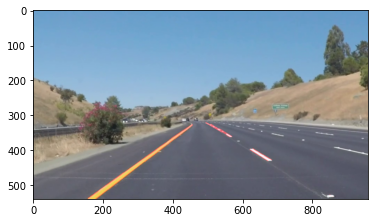

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

720
199
1124
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

720
199
1124



t:   1%|          | 3/251 [00:00<00:36,  6.86it/s, now=None]

720
197
1146
720
191
1156



t:   2%|▏         | 4/251 [00:00<00:33,  7.29it/s, now=None]

720
204
1120



t:   2%|▏         | 6/251 [00:00<00:39,  6.23it/s, now=None]

720
208
1113
720
201
1133



t:   3%|▎         | 8/251 [00:01<00:38,  6.25it/s, now=None]

720
220
1127
720
208
1136



t:   4%|▍         | 10/251 [00:01<00:45,  5.33it/s, now=None]

720
217
1143
720
236
1145



t:   5%|▍         | 12/251 [00:02<00:40,  5.92it/s, now=None]

720
226
1156
720
217
1145



t:   6%|▌         | 14/251 [00:02<00:37,  6.33it/s, now=None]

720
208
1136
720
227
1159



t:   6%|▋         | 16/251 [00:02<00:32,  7.23it/s, now=None]

720
226
1163
720
220
1123



t:   7%|▋         | 18/251 [00:02<00:29,  7.78it/s, now=None]

720
216
1152
720
225
1110



t:   8%|▊         | 20/251 [00:03<00:30,  7.62it/s, now=None]

720
221
1147



t:   8%|▊         | 21/251 [00:03<00:37,  6.17it/s, now=None]

720
228
1109
720
222
1126



t:   9%|▉         | 22/251 [00:03<00:36,  6.33it/s, now=None]

720
232
1143



t:  10%|▉         | 24/251 [00:03<00:42,  5.31it/s, now=None]

720
230
1140
720


t:  10%|▉         | 25/251 [00:04<00:40,  5.57it/s, now=None]


206
1127
720
222
1130



t:  11%|█         | 27/251 [00:04<00:32,  6.84it/s, now=None]

720
210
1115
720
224
1126



t:  12%|█▏        | 30/251 [00:07<01:49,  2.02it/s, now=None]

720
210
1094
720
213
1108
720


t:  12%|█▏        | 31/251 [00:07<01:23,  2.63it/s, now=None]


218
1133
720
208
1137



t:  13%|█▎        | 33/251 [00:07<00:52,  4.11it/s, now=None]

720
199
1105
720
197
1127
720


t:  14%|█▍        | 35/251 [00:07<00:42,  5.06it/s, now=None]


207
1130
720
220
1145
720


t:  15%|█▍        | 37/251 [00:07<00:36,  5.91it/s, now=None]


201
1132
720
206
1133



t:  16%|█▌        | 39/251 [00:08<00:30,  7.00it/s, now=None]

720
188
1134
720
206
1103



t:  16%|█▋        | 41/251 [00:08<00:29,  7.23it/s, now=None]

720
204
1130
720
217
1133



t:  17%|█▋        | 43/251 [00:08<00:26,  7.71it/s, now=None]

720
198
1142
720
216
1120



t:  18%|█▊        | 45/251 [00:08<00:30,  6.74it/s, now=None]

720
211
1102



t:  18%|█▊        | 46/251 [00:09<00:34,  5.90it/s, now=None]

720
199
1130



t:  19%|█▊        | 47/251 [00:09<00:36,  5.63it/s, now=None]

720
226
1080
720


t:  19%|█▉        | 48/251 [00:09<00:37,  5.37it/s, now=None]


204
1120
720


t:  20%|█▉        | 49/251 [00:09<00:34,  5.84it/s, now=None]


218
1133
720
214
1150



t:  20%|██        | 51/251 [00:10<00:35,  5.59it/s, now=None]

720
210
1134
720
224
1109



t:  21%|██        | 52/251 [00:10<00:32,  6.05it/s, now=None]

720
198
1089



t:  22%|██▏       | 54/251 [00:13<02:18,  1.43it/s, now=None]

720
230
1111
720
204
1104



t:  22%|██▏       | 56/251 [00:13<01:19,  2.45it/s, now=None]

720
203
1119
720
219
1118



t:  23%|██▎       | 58/251 [00:13<00:54,  3.54it/s, now=None]

720
210
1089
720
222
1124



t:  24%|██▎       | 59/251 [00:13<00:51,  3.73it/s, now=None]

720
199
1115



t:  24%|██▍       | 61/251 [00:14<00:47,  3.99it/s, now=None]

720
208
1146
720
199
1120



t:  25%|██▌       | 63/251 [00:14<00:35,  5.26it/s, now=None]

720
204
1116
720
215
1113



t:  26%|██▌       | 65/251 [00:15<00:35,  5.24it/s, now=None]

720
241
1126
720
255
1134



t:  27%|██▋       | 67/251 [00:15<00:29,  6.23it/s, now=None]

720
225
1127
720
211
1146



t:  27%|██▋       | 69/251 [00:15<00:26,  6.98it/s, now=None]

720
223
1147
720
211
1134



t:  28%|██▊       | 71/251 [00:18<02:13,  1.35it/s, now=None]

720
212
1153
720
218
1155



t:  29%|██▉       | 73/251 [00:18<01:16,  2.33it/s, now=None]

720
224
1165
720
225
1141



t:  30%|██▉       | 75/251 [00:18<00:49,  3.53it/s, now=None]

720
235
1167
720
238
1163



t:  31%|███       | 77/251 [00:19<00:35,  4.87it/s, now=None]

720
224
1174
720
228
1166



t:  31%|███▏      | 79/251 [00:19<00:30,  5.73it/s, now=None]

720
239
1165
720
242
1161



t:  32%|███▏      | 81/251 [00:19<00:26,  6.36it/s, now=None]

720
261
1150
720
244
1171



t:  33%|███▎      | 83/251 [00:19<00:27,  6.03it/s, now=None]

720
247
1178
720
241
1172



t:  34%|███▍      | 85/251 [00:20<00:25,  6.50it/s, now=None]

720
207
1174
720
233
1175



t:  35%|███▍      | 87/251 [00:20<00:26,  6.07it/s, now=None]

720
232
1162
720


t:  35%|███▌      | 88/251 [00:20<00:26,  6.08it/s, now=None]


263
1150
720
275
1170



t:  36%|███▌      | 90/251 [00:21<00:25,  6.41it/s, now=None]

720
273
1164
720
263
1172



t:  37%|███▋      | 92/251 [00:23<01:49,  1.46it/s, now=None]

720
255
1176
720
235
1184



t:  37%|███▋      | 94/251 [00:24<01:04,  2.44it/s, now=None]

720
276
1177
720
278
1181



t:  38%|███▊      | 96/251 [00:24<00:52,  2.98it/s, now=None]

720
271
1178
720


t:  39%|███▊      | 97/251 [00:24<00:46,  3.32it/s, now=None]


257
1168
720
256
1168



t:  39%|███▉      | 98/251 [00:25<00:49,  3.11it/s, now=None]

720
277
1022



t:  39%|███▉      | 99/251 [00:25<01:03,  2.40it/s, now=None]

720
271
1028



t:  40%|███▉      | 100/251 [00:26<01:03,  2.38it/s, now=None]

720
270
1029



t:  41%|████      | 102/251 [00:29<01:59,  1.25it/s, now=None]

720
274
1162
720
265
1178



t:  41%|████▏     | 104/251 [00:29<01:07,  2.18it/s, now=None]

720
255
1182
720
252
1169



t:  42%|████▏     | 106/251 [00:29<00:43,  3.30it/s, now=None]

720
253
1169
720
260
1156



t:  43%|████▎     | 108/251 [00:29<00:31,  4.52it/s, now=None]

720
170
1129
720
195
1055



t:  44%|████▍     | 110/251 [00:30<00:27,  5.21it/s, now=None]

720
167
1132
720
238
1114



t:  45%|████▍     | 112/251 [00:30<00:24,  5.72it/s, now=None]

720
232
1096
720
207
1116



t:  45%|████▌     | 113/251 [00:30<00:25,  5.46it/s, now=None]

720
209
1171



t:  46%|████▌     | 115/251 [00:31<00:25,  5.43it/s, now=None]

720
200
1163
720
197
1154



t:  47%|████▋     | 117/251 [00:31<00:23,  5.59it/s, now=None]

720
209
1160
720
221
1105



t:  47%|████▋     | 119/251 [00:31<00:21,  6.09it/s, now=None]

720
202
1170
720
209
1148



t:  48%|████▊     | 121/251 [00:34<01:26,  1.51it/s, now=None]

720
189
1154
720
100
1163



t:  49%|████▉     | 123/251 [00:35<00:56,  2.27it/s, now=None]

720
154
1145
720
160
1139



t:  50%|████▉     | 125/251 [00:35<00:36,  3.44it/s, now=None]

720
179
1136
720
198
1065



t:  50%|█████     | 126/251 [00:35<00:31,  3.94it/s, now=None]

720
206
1093



t:  51%|█████     | 128/251 [00:36<00:29,  4.24it/s, now=None]

720
164
1106
720
172
1127



t:  52%|█████▏    | 130/251 [00:36<00:24,  4.91it/s, now=None]

720
169
1130
720
204
1123



t:  53%|█████▎    | 132/251 [00:36<00:20,  5.81it/s, now=None]

720
191
1132
720
191
1135



t:  53%|█████▎    | 133/251 [00:36<00:20,  5.88it/s, now=None]

720
181
1137



t:  54%|█████▍    | 135/251 [00:37<00:22,  5.15it/s, now=None]

720
182
1149
720
176
1146



t:  55%|█████▍    | 137/251 [00:40<01:19,  1.43it/s, now=None]

720
181
1151
720


t:  55%|█████▍    | 138/251 [00:40<01:01,  1.83it/s, now=None]


184
1115
720


t:  55%|█████▌    | 139/251 [00:40<00:47,  2.34it/s, now=None]


180
1137
720
183
1126



t:  56%|█████▌    | 141/251 [00:40<00:31,  3.47it/s, now=None]

720
183
1119
720
182
1135



t:  57%|█████▋    | 143/251 [00:41<00:24,  4.41it/s, now=None]

720
125
1128
720
160
1139



t:  58%|█████▊    | 145/251 [00:41<00:19,  5.36it/s, now=None]

720
161
1143
720
136
1140



t:  59%|█████▊    | 147/251 [00:41<00:17,  6.09it/s, now=None]

720
164
1142
720
154
1143



t:  59%|█████▉    | 149/251 [00:41<00:16,  6.31it/s, now=None]

720
167
1122
720
160
1144



t:  60%|██████    | 151/251 [00:42<00:18,  5.38it/s, now=None]

720
171
1095
720
160
1124



t:  61%|██████    | 153/251 [00:42<00:15,  6.47it/s, now=None]

720
175
1098
720
173
1123



t:  61%|██████▏   | 154/251 [00:42<00:14,  6.80it/s, now=None]

720
175
1111



t:  62%|██████▏   | 156/251 [00:45<01:06,  1.42it/s, now=None]

720
168
1116
720
175
1097



t:  63%|██████▎   | 158/251 [00:46<00:39,  2.35it/s, now=None]

720
180
1131
720
163
1076



t:  64%|██████▎   | 160/251 [00:46<00:28,  3.25it/s, now=None]

720
161
1075
720


t:  64%|██████▍   | 161/251 [00:46<00:23,  3.83it/s, now=None]


149
1088
720
162
1106



t:  65%|██████▍   | 163/251 [00:46<00:17,  5.04it/s, now=None]

720
158
1112
720
139
1109



t:  66%|██████▌   | 165/251 [00:47<00:16,  5.20it/s, now=None]

720
153
1107
720
165
1121



t:  67%|██████▋   | 167/251 [00:47<00:15,  5.33it/s, now=None]

720
160
1114
720
170
1114



t:  67%|██████▋   | 168/251 [00:47<00:17,  4.88it/s, now=None]

720
168
1112



t:  68%|██████▊   | 170/251 [00:50<01:03,  1.28it/s, now=None]

720
169
1096
720


t:  68%|██████▊   | 171/251 [00:50<00:47,  1.69it/s, now=None]


193
1108
720
192
1101



t:  69%|██████▉   | 173/251 [00:51<00:28,  2.78it/s, now=None]

720
197
1143
720
188
1114



t:  70%|██████▉   | 175/251 [00:51<00:18,  4.04it/s, now=None]

720
211
1132
720
193
1119



t:  71%|███████   | 177/251 [00:51<00:14,  5.09it/s, now=None]

720
208
1144
720
182
1144



t:  71%|███████▏  | 179/251 [00:52<00:12,  5.57it/s, now=None]

720
180
1152



t:  72%|███████▏  | 180/251 [00:52<00:13,  5.13it/s, now=None]

720
199
1120
720
203
1137



t:  73%|███████▎  | 182/251 [00:52<00:12,  5.63it/s, now=None]

720
212
1107
720
208
1141



t:  73%|███████▎  | 184/251 [00:52<00:10,  6.58it/s, now=None]

720
210
1137
720
223
1147



t:  74%|███████▎  | 185/251 [00:53<00:09,  6.75it/s, now=None]

720
219
1141



t:  75%|███████▍  | 187/251 [00:56<00:49,  1.30it/s, now=None]

720
245
1146
720
221
1130



t:  75%|███████▌  | 189/251 [00:56<00:27,  2.26it/s, now=None]

720
232
1145
720
213
1158



t:  76%|███████▌  | 191/251 [00:57<00:18,  3.18it/s, now=None]

720
240
1142
720
220
1141



t:  77%|███████▋  | 193/251 [00:57<00:12,  4.50it/s, now=None]

720
220
1166
720
227
1150



t:  78%|███████▊  | 195/251 [00:57<00:09,  5.72it/s, now=None]

720
220
1126
720
220
1133



t:  78%|███████▊  | 197/251 [00:57<00:08,  6.49it/s, now=None]

720
228
1165
720
225
1157



t:  79%|███████▉  | 199/251 [00:58<00:08,  5.99it/s, now=None]

720
213
1163
720
236
1144



t:  80%|████████  | 201/251 [00:58<00:07,  6.59it/s, now=None]

720
233
1173
720
229
1146



t:  81%|████████  | 203/251 [00:58<00:06,  7.13it/s, now=None]

720
233
1121
720
228
1147



t:  81%|████████▏ | 204/251 [00:58<00:06,  7.01it/s, now=None]

720
211
1168



t:  82%|████████▏ | 206/251 [01:02<00:38,  1.17it/s, now=None]

720
228
1134
720
250
1119



t:  83%|████████▎ | 208/251 [01:02<00:20,  2.07it/s, now=None]

720
255
1157
720
241
1154



t:  84%|████████▎ | 210/251 [01:02<00:12,  3.31it/s, now=None]

720
242
1147
720
245
1138



t:  84%|████████▍ | 211/251 [01:02<00:10,  3.92it/s, now=None]

720
226
1160



t:  85%|████████▍ | 213/251 [01:03<00:09,  4.19it/s, now=None]

720
234
1162
720
243
1183



t:  86%|████████▌ | 215/251 [01:03<00:06,  5.62it/s, now=None]

720
248
1176
720
245
1175



t:  86%|████████▋ | 217/251 [01:03<00:05,  6.31it/s, now=None]

720
246
1184
720
256
1162



t:  87%|████████▋ | 219/251 [01:04<00:04,  6.68it/s, now=None]

720
254
1174
720
236
1184



t:  88%|████████▊ | 221/251 [01:04<00:04,  6.19it/s, now=None]

720
231
1174
720
253
1163



t:  89%|████████▉ | 223/251 [01:07<00:21,  1.32it/s, now=None]

720
239
1176
720
256
1154



t:  90%|████████▉ | 225/251 [01:07<00:11,  2.21it/s, now=None]

720
240
1148
720
236
1176



t:  90%|█████████ | 227/251 [01:08<00:06,  3.47it/s, now=None]

720
258
1166
720
263
1138



t:  91%|█████████ | 229/251 [01:08<00:04,  4.58it/s, now=None]

720
257
1118
720
252
1115



t:  92%|█████████▏| 231/251 [01:08<00:03,  5.82it/s, now=None]

720
265
1151
720
260
1162



t:  93%|█████████▎| 233/251 [01:09<00:02,  6.48it/s, now=None]

720
264
1100
720
245
1147



t:  94%|█████████▎| 235/251 [01:09<00:02,  6.09it/s, now=None]

720
271
1165
720
251
1156



t:  94%|█████████▍| 237/251 [01:09<00:02,  6.63it/s, now=None]

720
214
1163
720
231
1160



t:  95%|█████████▌| 239/251 [01:09<00:01,  7.03it/s, now=None]

720
225
1160
720
260
1139



t:  96%|█████████▌| 241/251 [01:10<00:01,  7.29it/s, now=None]

720
225
1159
720
244
1159



t:  96%|█████████▋| 242/251 [01:10<00:01,  7.20it/s, now=None]

720
244
1130



t:  97%|█████████▋| 244/251 [01:13<00:05,  1.30it/s, now=None]

720
244
1160
720
222
1164



t:  98%|█████████▊| 246/251 [01:14<00:02,  2.14it/s, now=None]

720
233
1149
720
242
1158



t:  99%|█████████▉| 248/251 [01:14<00:00,  3.34it/s, now=None]

720
242
1151
720
224
1160



t: 100%|█████████▉| 250/251 [01:14<00:00,  4.56it/s, now=None]

720
239
1160
720
241
1156



t: 100%|██████████| 251/251 [01:14<00:00,  5.13it/s, now=None]
                                                              

720
250
1138


t:  39%|███▉      | 98/251 [11:45<00:24,  6.30it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 1min 20s


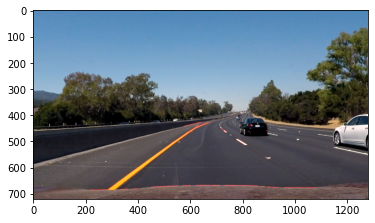

In [10]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(9,10)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))